## make semi supervised

In [1]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner2.dataset import anndata
import pandas as pd
# to comment in your case
from depmapomics import tracker as track

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

import celligner2

Loading BokehJS ...

In [3]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
dataset = read_h5ad("temp/celligner_multi.h5ad")

In [5]:
# removing ultra rare samples

In [6]:
MINEXAMPLE=4

In [7]:
todrop = []
for k, v in Counter(dataset.obs["disease_type"]).items():
    if v <MINEXAMPLE:
        print(k)
        todrop.append(k)
loc = dataset.obs["disease_type"].isin(todrop)
dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

endometrial_squamous
glassy_cell_carcinoma
breast_adenocarcinoma
ovary_carcinoma
thyroid_squamous
unspecified_leukemia
b-cell,_non-hodgkins,_burkitts
cervical_adenocarcinoma
uterine_sarcoma
teratoma
mullerian_carcinoma
sccoht
merkel_cell_carcinoma
thyroid_sarcoma
duodenal_adenocarcinoma
b-cell
clear_cell_carcinoma
krukenberg_tumor
chondrosarcoma
choriocarcinoma
mixed_germ_cell
endometrial_adenosquamous
endometrial_stromal_sarcoma
thymic_carcinoma
brenner_tumor
atl
prostate_small_cell
endocrine
prostate_hyperplasia
lung_carcinoid
angiosarcoma
acinar_cell_carcinoma
melanotic_neuroectodermal_tumor
gliomatosis_cerebri
nut_midline_carcinoma
myoepithelial_carcinoma
myeloid_neoplasm_nos
neurofibroma
nasopharyngeal_carcinoma
perivascular_epithelioid_cell_neoplasms
clear_cell_carcinoma_of_cervix
epithelioid_hemangioendothelioma
juvenile_myelomonocytic_leukemia
alveolar_sarcoma
pleuropulmonary_blastoma
craniopharyngioma
adrenocortical_adenoma
rosette_forming_glioneuronal_tumor
neuroendocrine_car

In [8]:
todrop = []
for k, v in Counter(dataset.obs["lineage"]).items():
    if v <MINEXAMPLE:
        print(k)
        todrop.append(k)
loc = dataset.obs["lineage"].isin(todrop)
dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

fibroblast_upper_aerodigestive
fibroblast_lymphocyte
fibroblast_colorectal
fibroblast_soft_tissue
fibroblast_urinary_tract


In [9]:
for val in ['ends', 'reference', 'method', 'sequencer']:
    print(val, set(dataset.obs[val]))

ends {'paired end'}
reference {'hg19', 'hg38'}
method {'bulk'}
sequencer {'Illlumina TruSeq', 'Illumina HiSeq 2000', 'Illumina HiSeq 4000'}


In [10]:
low_nan_genes = np.isnan(dataset.X).sum(0)<len(dataset.X)*0.2
loc = np.argsort(np.nanvar(dataset.X[:,low_nan_genes], 0))[-3000:]
dataset = AnnData(dataset.X[:,low_nan_genes][:,loc], dataset.obs, dataset.var[low_nan_genes].iloc[loc])

In [11]:
#TODO: try batch norm use_bn=True, use_ln=False, https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
#TODO

In [12]:
dataset.obs.replace({'u':'U', 'other': 'U', '': 'none'}, inplace=True)

In [13]:
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='ccle'), 'align'] = 'STAR'
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='met500'), 'align'] = 'STAR'

In [14]:
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='ccle'), 'counter'] = 'RSEM'
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='met500'), 'counter'] = 'RSEM'

we can use estimation for the missing values in the conditional dataset

In [15]:
dataset.obs.loc[(dataset.obs['cell_format']=='U') & dataset.obs['dataset'].isin(['hcmi','cclf']), "cell_format"] = ["2D","3D","3D","3D","3D"]# = evaluator.adata_latent.obs.loc[dataset.obs.loc[(dataset.obs['cell_format']=='U')].index, 'cell_format_pred']

In [16]:
print(set(dataset.obs.loc[(dataset.obs['cell_format']=='U')].dataset))
dataset.obs['cell_format'] = dataset.obs['cell_format'].cat.rename_categories({'U':'none'})

{'met500', 'tcga'}


In [17]:
print(set(dataset.obs.loc[(dataset.obs['conservation']=='U')].dataset))
dataset.obs['conservation'] = dataset.obs['conservation'].cat.rename_categories({'U':'none'})

{'met500', 'tcga'}


In [18]:
(np.isnan(dataset.X).sum(0)>3000).sum()

0

In [19]:
cols = ['dataset','reference','sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format']

In [20]:
pred = ['lineage', 'collection_site', 'age', "sex", 'disease_type', 'doublingt' , 'cell_type', 'morphology', 'ethnicity', 'instability', 'hasebv', 'base_media', 'stage','passage_number','contamination']

In [82]:
dataset.obs.conservation

sample_id
ACH-001113               fresh
ACH-001289               fresh
ACH-001339               fresh
ACH-001538               fresh
ACH-000242               fresh
                         ...  
HCM-BROD-0036-C41-85A    fresh
HCM-BROD-0025-C16-85A    fresh
HCM-BROD-0002-C71-85A    fresh
HCM-BROD-0043-C16-85B    fresh
HCM-CSHL-0065-C20-85A    fresh
Name: conservation, Length: 14926, dtype: category
Categories (3, object): ['none', 'fresh', 'frozen']

In [37]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset.copy(),
    condition_keys=cols,
    predictor_keys=pred,
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32, 64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8,
    #mmd_on='y1'
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 27
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 320 

Decoder Architecture:
	First Layer in, out and cond:  16 128 27
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |███-----------------| 19.3%  - val_loss: 8043.6398763021 - val_recon_loss: 4780.6340006510 - val_kl_loss: 65.5215560913 - val_class_ce_loss: 395.9164594650 - val_mmd_loss: 2867.07090861004
ADJUSTED LR
 |████----------------| 21.7%  - val_loss: 7864.9990234375 - val_recon_loss: 4796.4401041667 - val_kl_loss: 65.5728858948 - val_class_ce_loss: 368.4650513093 - val_mmd_loss: 2700.0728800456
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 43


In [40]:
cl2.save('./temp/model', overwrite=True)

In [37]:
# doesn't work, the model then outputs nans as latent factors.
cl2 = celligner2.CELLIGNER2.load(dir_path='./temp/model', adata=dataset)

AnnData object with n_obs × n_vars = 15064 × 3000
    obs: 'collection_site', 'disease_type', 'doublingt', 'method', 'reference', 'age', 'cell_type', 'ends', 'sequencer', 'participant_id', 'sex', 'base_media', 'morphology', 'dataset', 'ethnicity', 'instability', 'hasebv', 'tissue_id', 'sample_type', 'align', 'counter', 'passage_number', 'contamination', 'lineage', 'stage', 'conservation', 'cell_format', 'celligner2_size_factors'


TypeError: __init__() got an unexpected keyword argument 'input_dim'

In [38]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

we have a certain distribution of passage numbers only based on CCLF samples. looking at CCLE we expect high passages considerign they are historical cell lines. this is what we get

In [103]:
Counter(obs[(obs['passage_number']!="U")]['passage_number'])

Counter({'none': 12236, 'verylow': 6, 'medium': 39, 'high': 31, 'low': 14})

In [100]:
obs = evaluator.adata_latent.obs
Counter(obs[(obs['passage_number']=="U") & (obs.dataset=="ccle")]['passage_number_pred'])

Counter({'none': 766, 'high': 142, 'medium': 494, 'verylow': 9})

then it doesn't make any sense on tcga (we would expect low if anything else)

In [102]:
Counter(obs[(obs['passage_number']=="none") & (obs.dataset=="tcga")]['passage_number_pred'])

Counter({'none': 12236})

In [39]:
evaluator.get_class_quality(classes=['lineage', 'collection_site', 'age', "sex", 'disease_type', 'doublingt', 'cell_type', 'base_media', 'morphology', 'ethnicity', 'instability', 'hasebv', 'passage_number', 'contamination', 'stage'])

lineage
all predicted categories:  {'gastric', 'kidney', 'lymphocyte', 'pancreas', 'plasma_cell', 'fibroblast_bone', 'breast', 'uterus', 'fibroblast_skin', 'gall_bladder', 'prostate', 'skin', 'cervix', 'soft_tissue', 'blood', 'thyroid', 'peripheral_nervous_system', 'esophagus', 'oral', 'adrenal', 'bone', 'bladder', 'central_nervous_system', 'eye', 'upper_aerodigestive', 'bile_duct', 'ovary', 'ampulla of vater', 'liver', 'germ_cell', 'lung', 'testis', 'colon', 'brain', 'stomach'}
accuracy:  0.928644171362618
F1 Score: 0.69


collection_site
all predicted categories:  {'pancreatic_tail', 'peritoneal', 'endometrium', 'kidney', 'pancreas', 'large_intestine', 'heart', 'ileum', 'lymph_node', 'bone_marrow', 'breast', 'post_mortem_blood', 'haematopoietic_and_lymphoid_tissue', 'sigmoid_colon', 'autonomic_ganglia', 'head_and_neck_region', 'cerebellum', 'prostate', 'skin', 'upper_aerodigestive_tract', 'biliatract', 'fibroblast', 'pleura', 'soft_tissue', 'posterior_mediastil_(mediastinum)', 'thyro

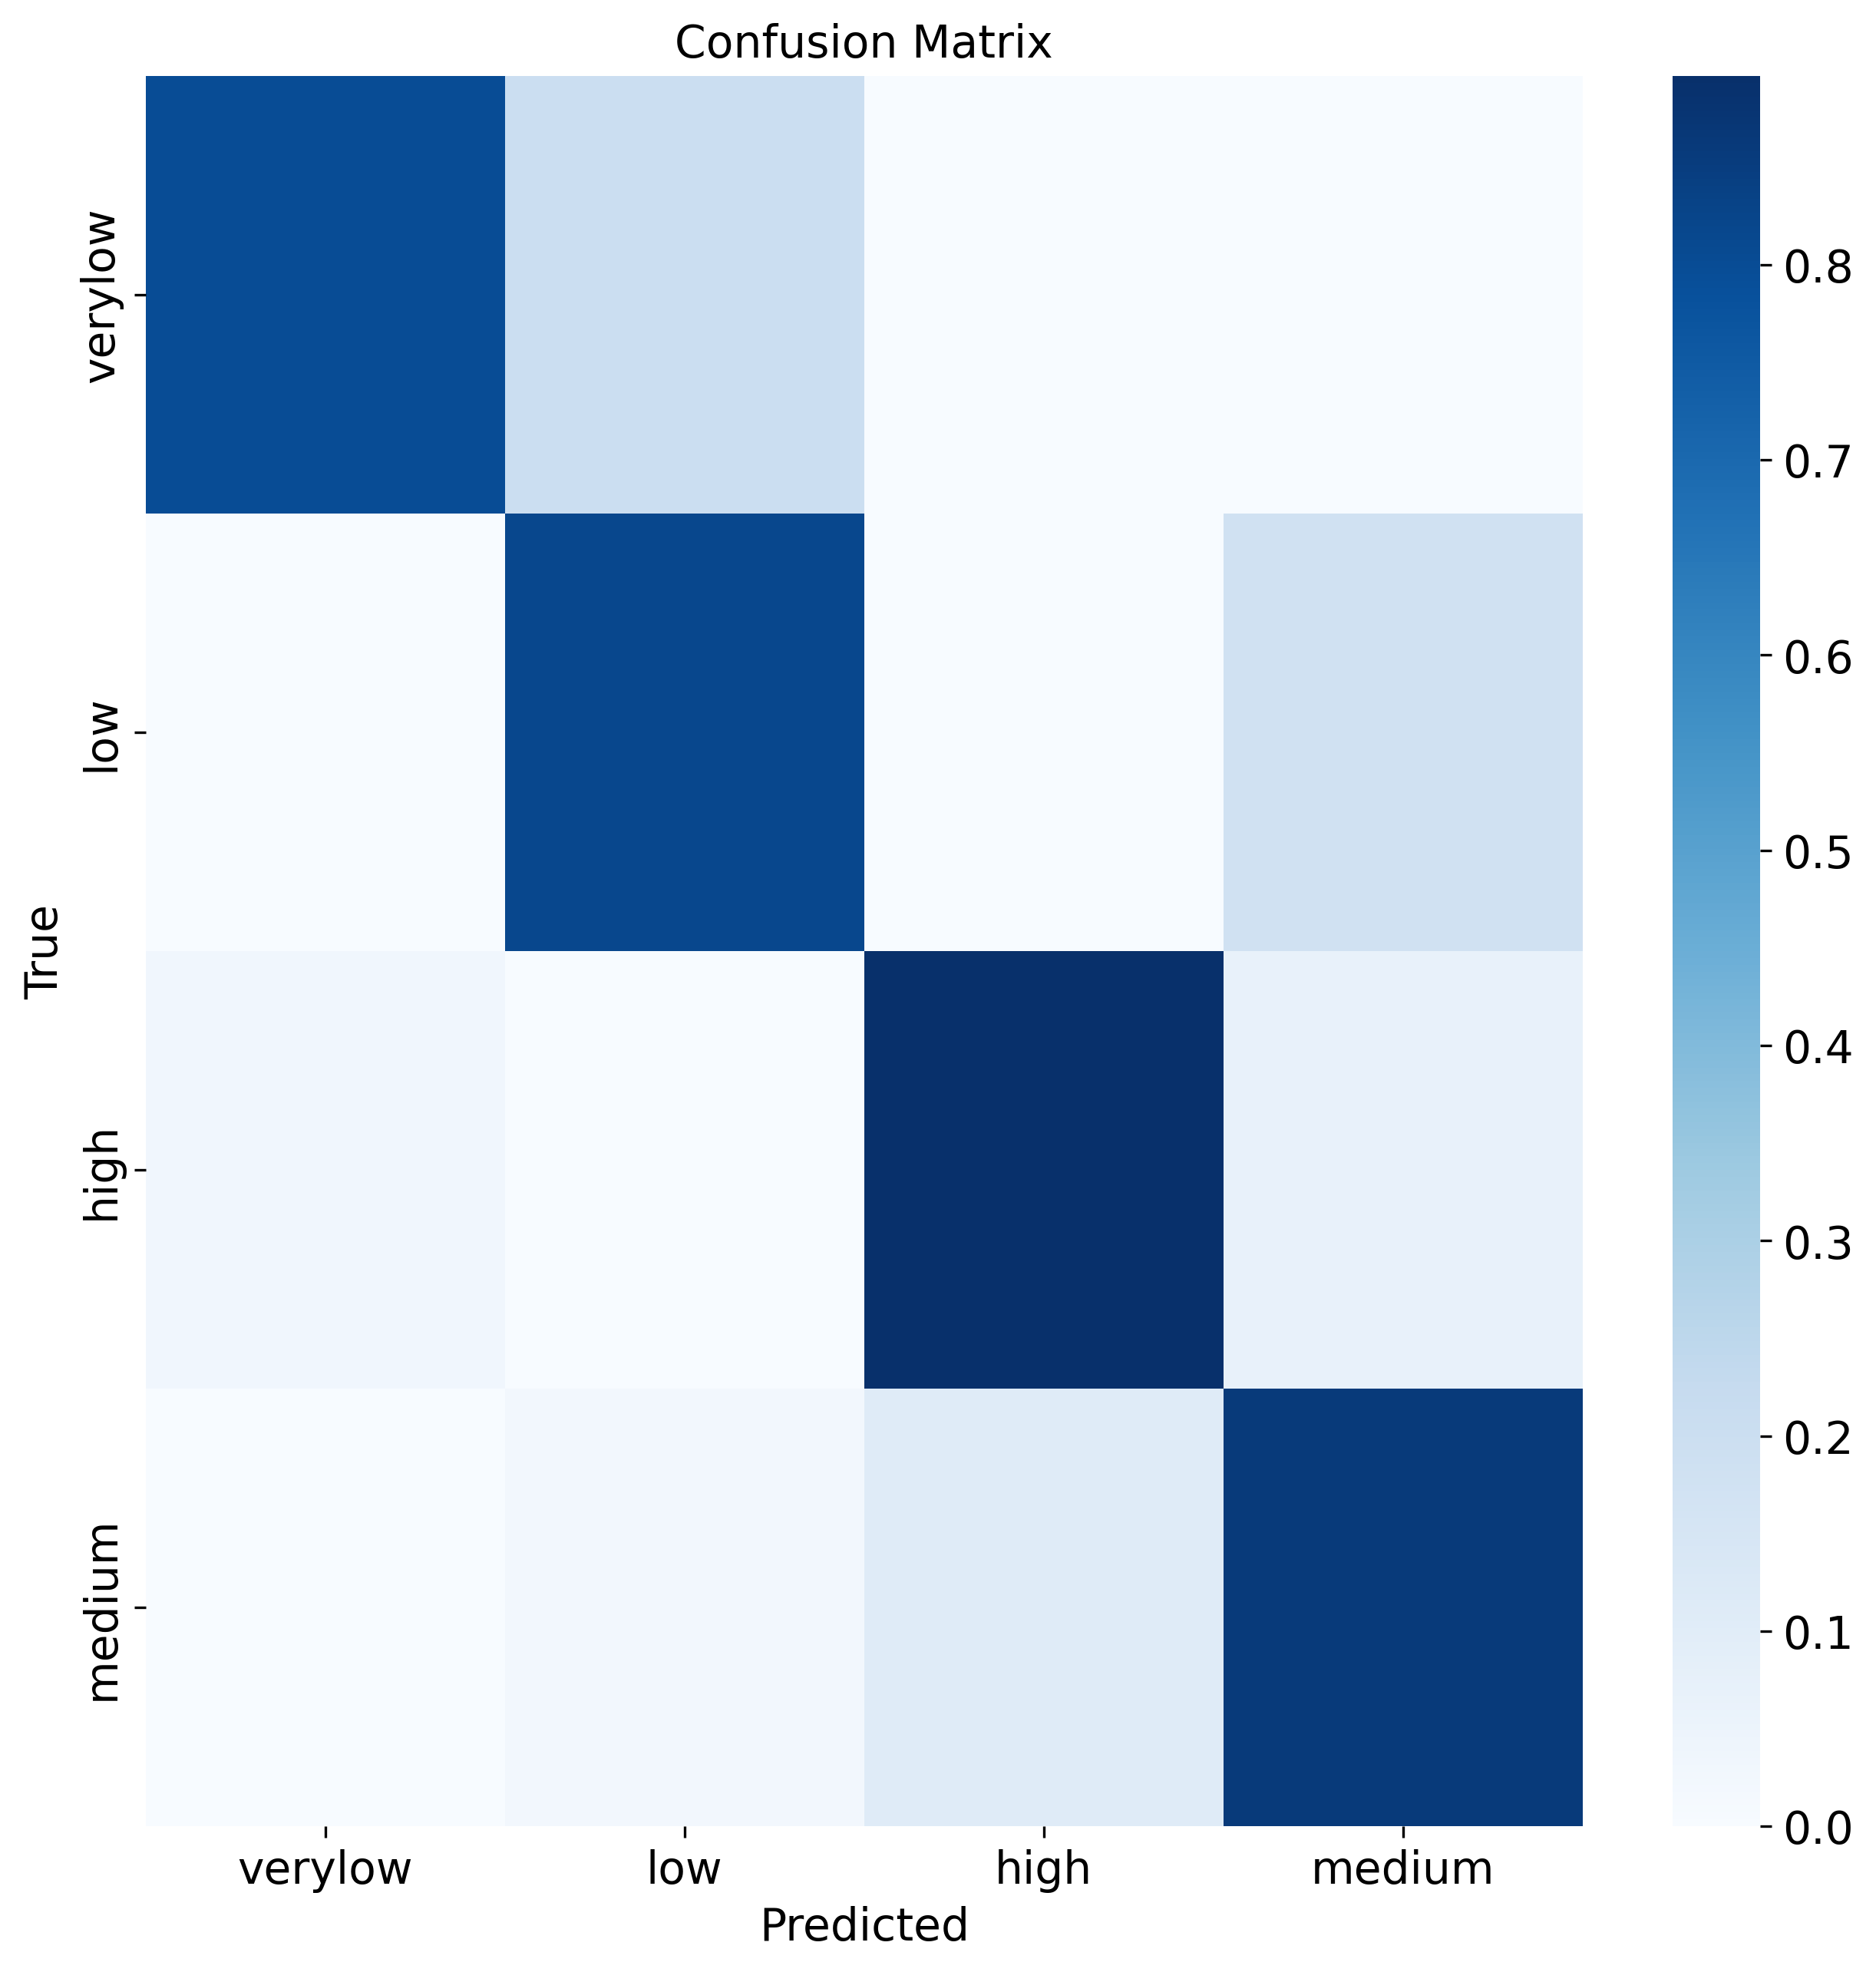

In [24]:
conf = evaluator.getconfusionMatrix(on="passage_number", only=None, figsize=(10,10))

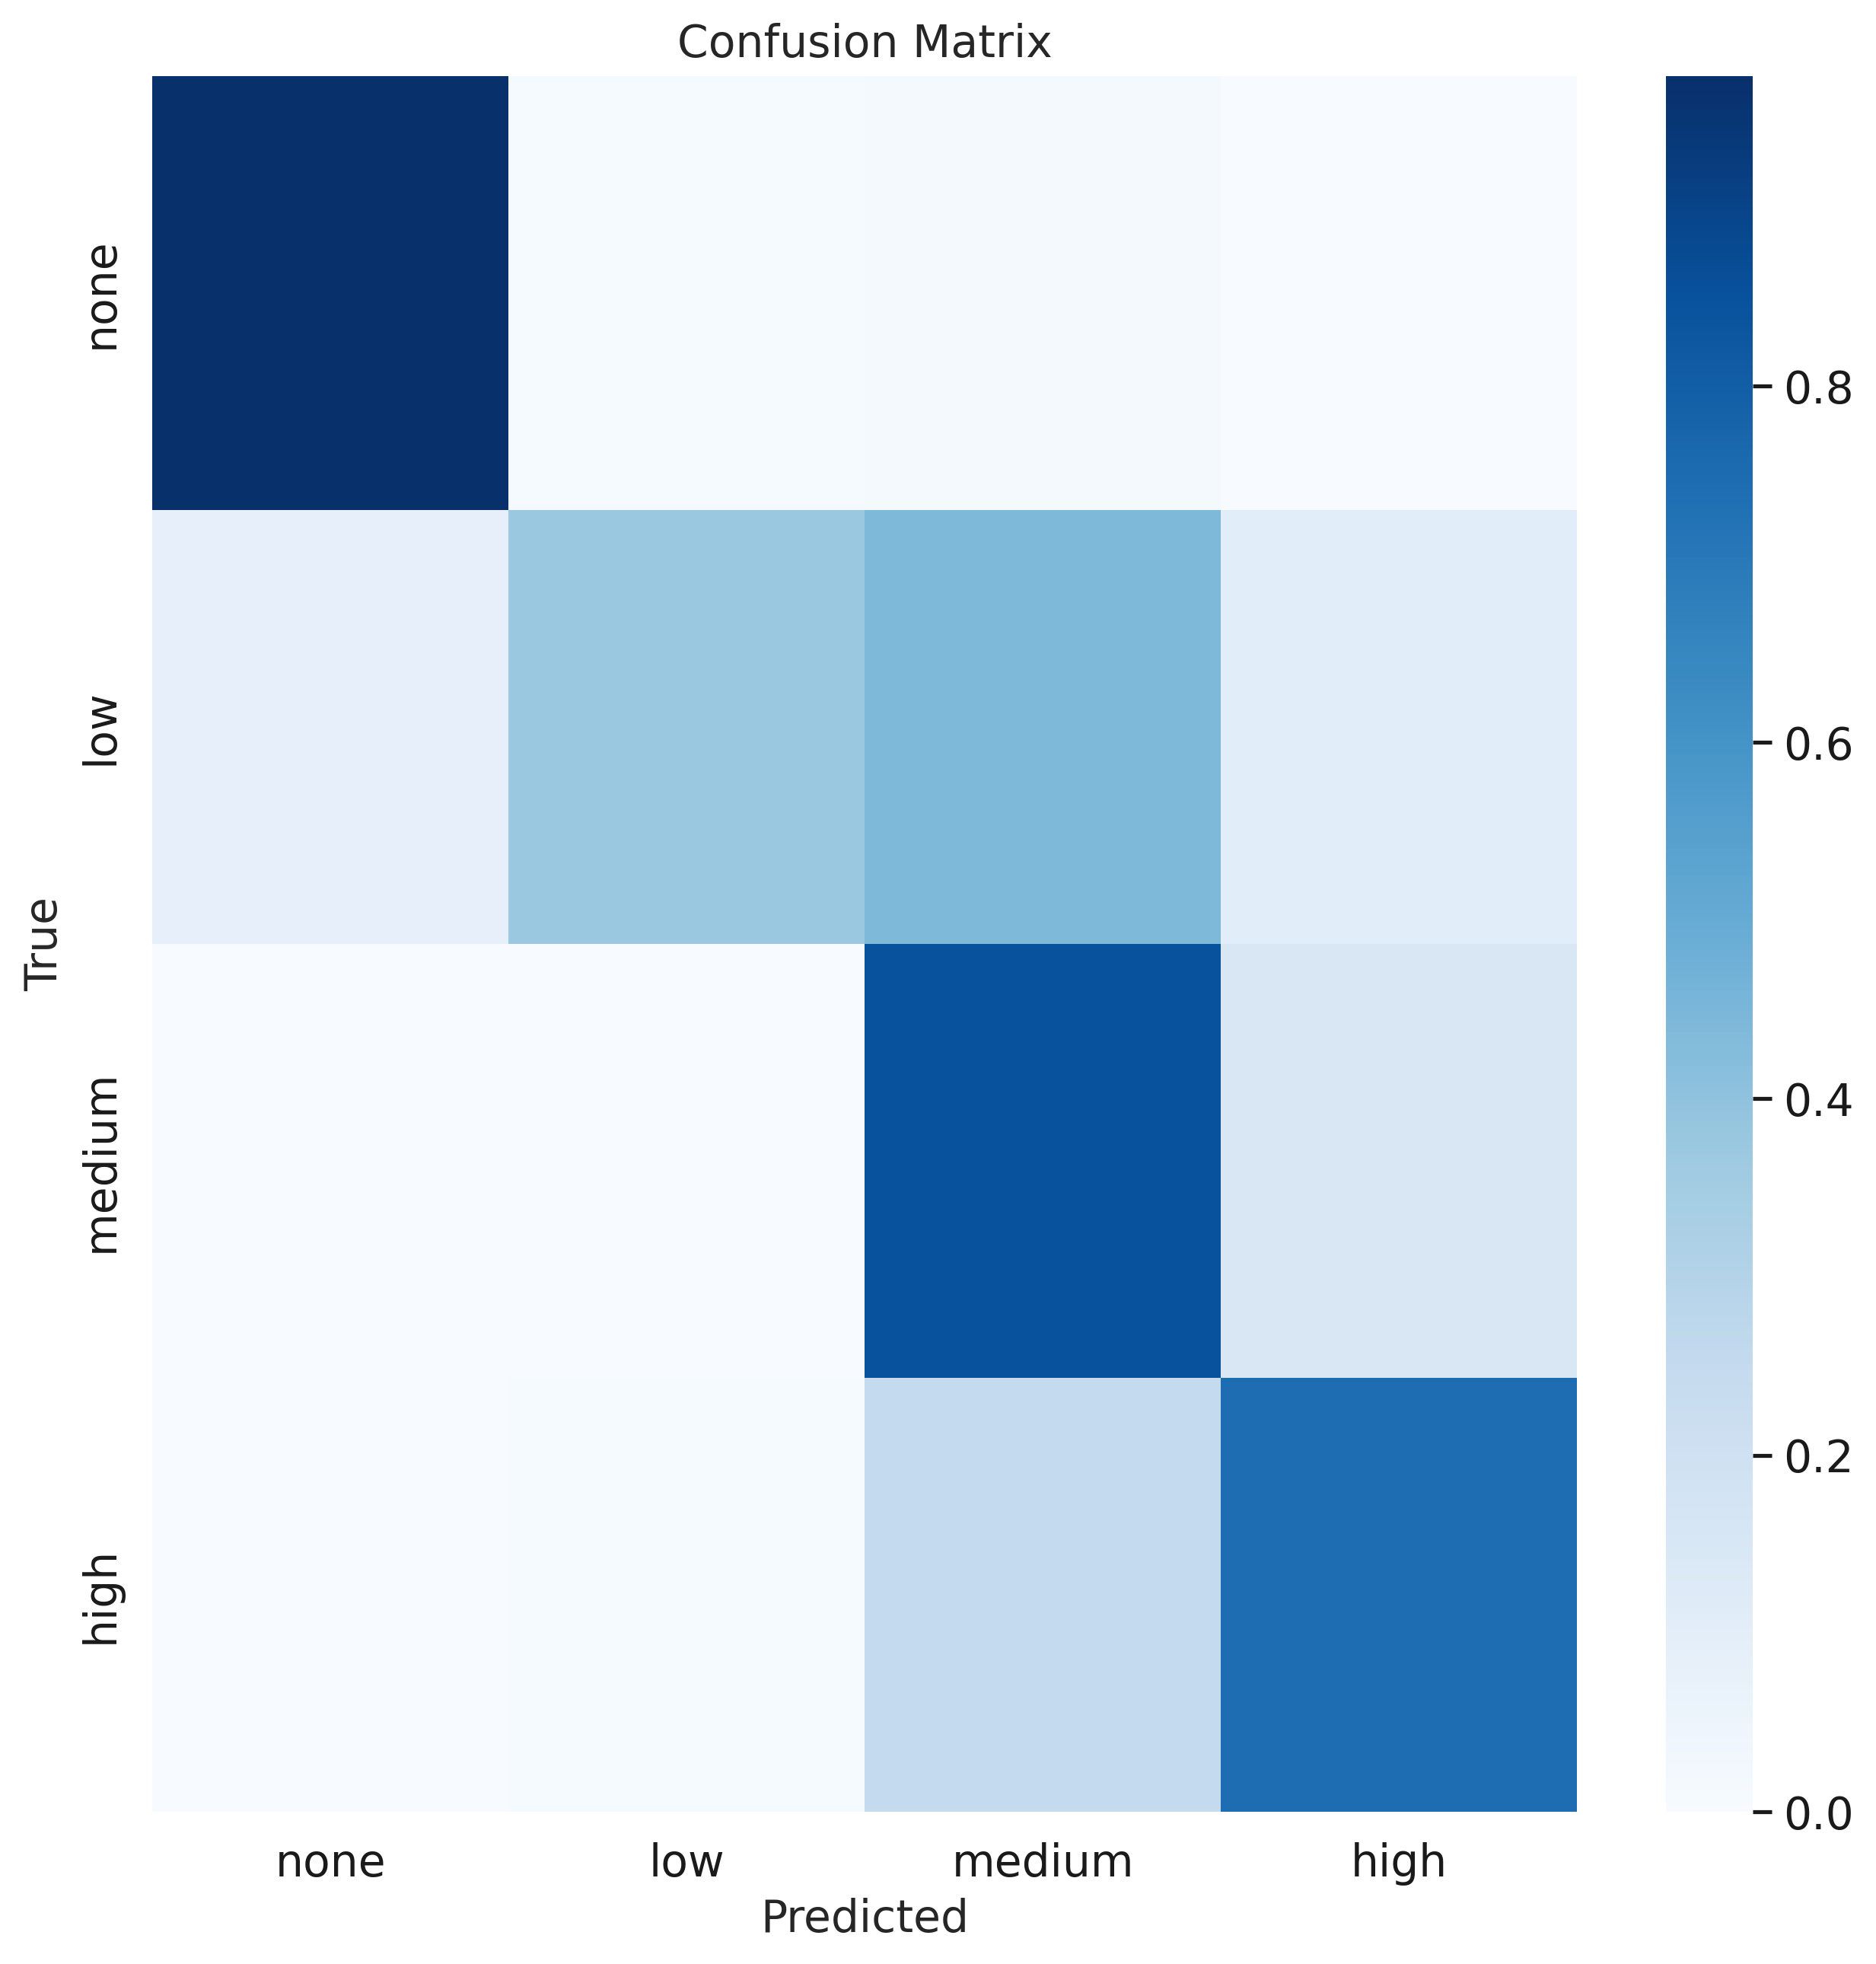

In [128]:
conf = evaluator.getconfusionMatrix(on="contamination", only=None)

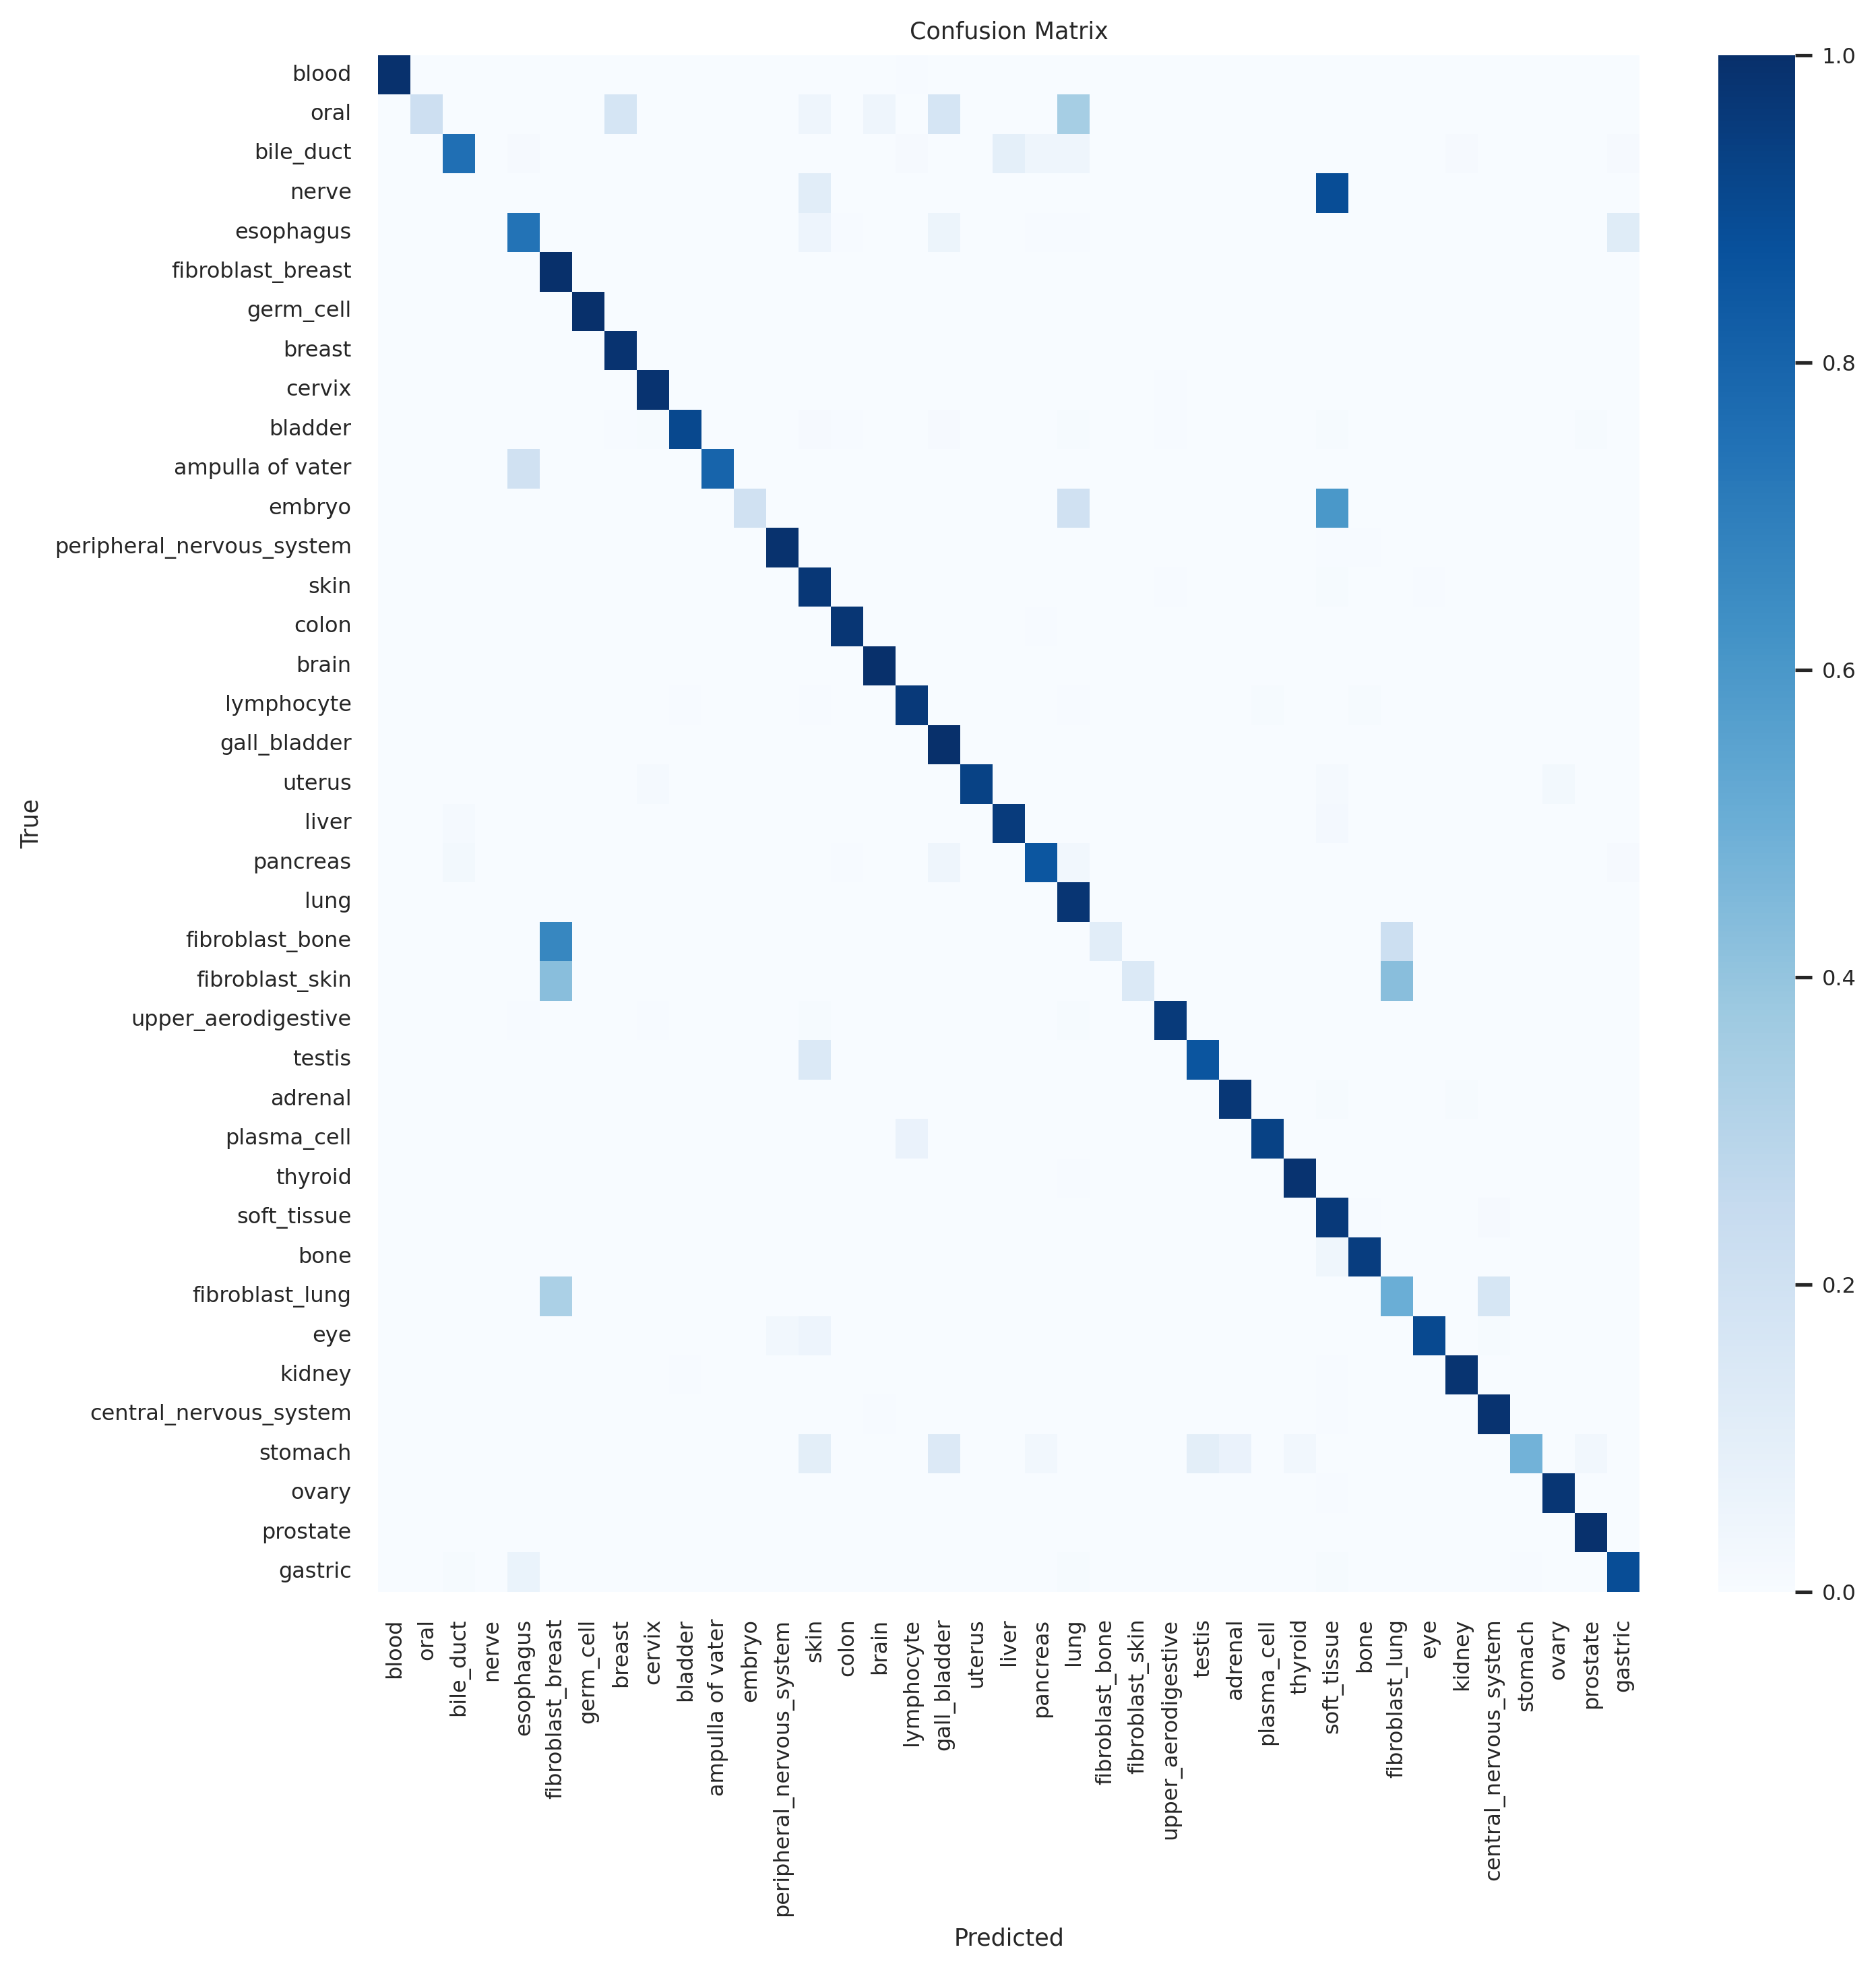

In [133]:
conf = evaluator.getconfusionMatrix(on="lineage", only=None, font_scale=.7)

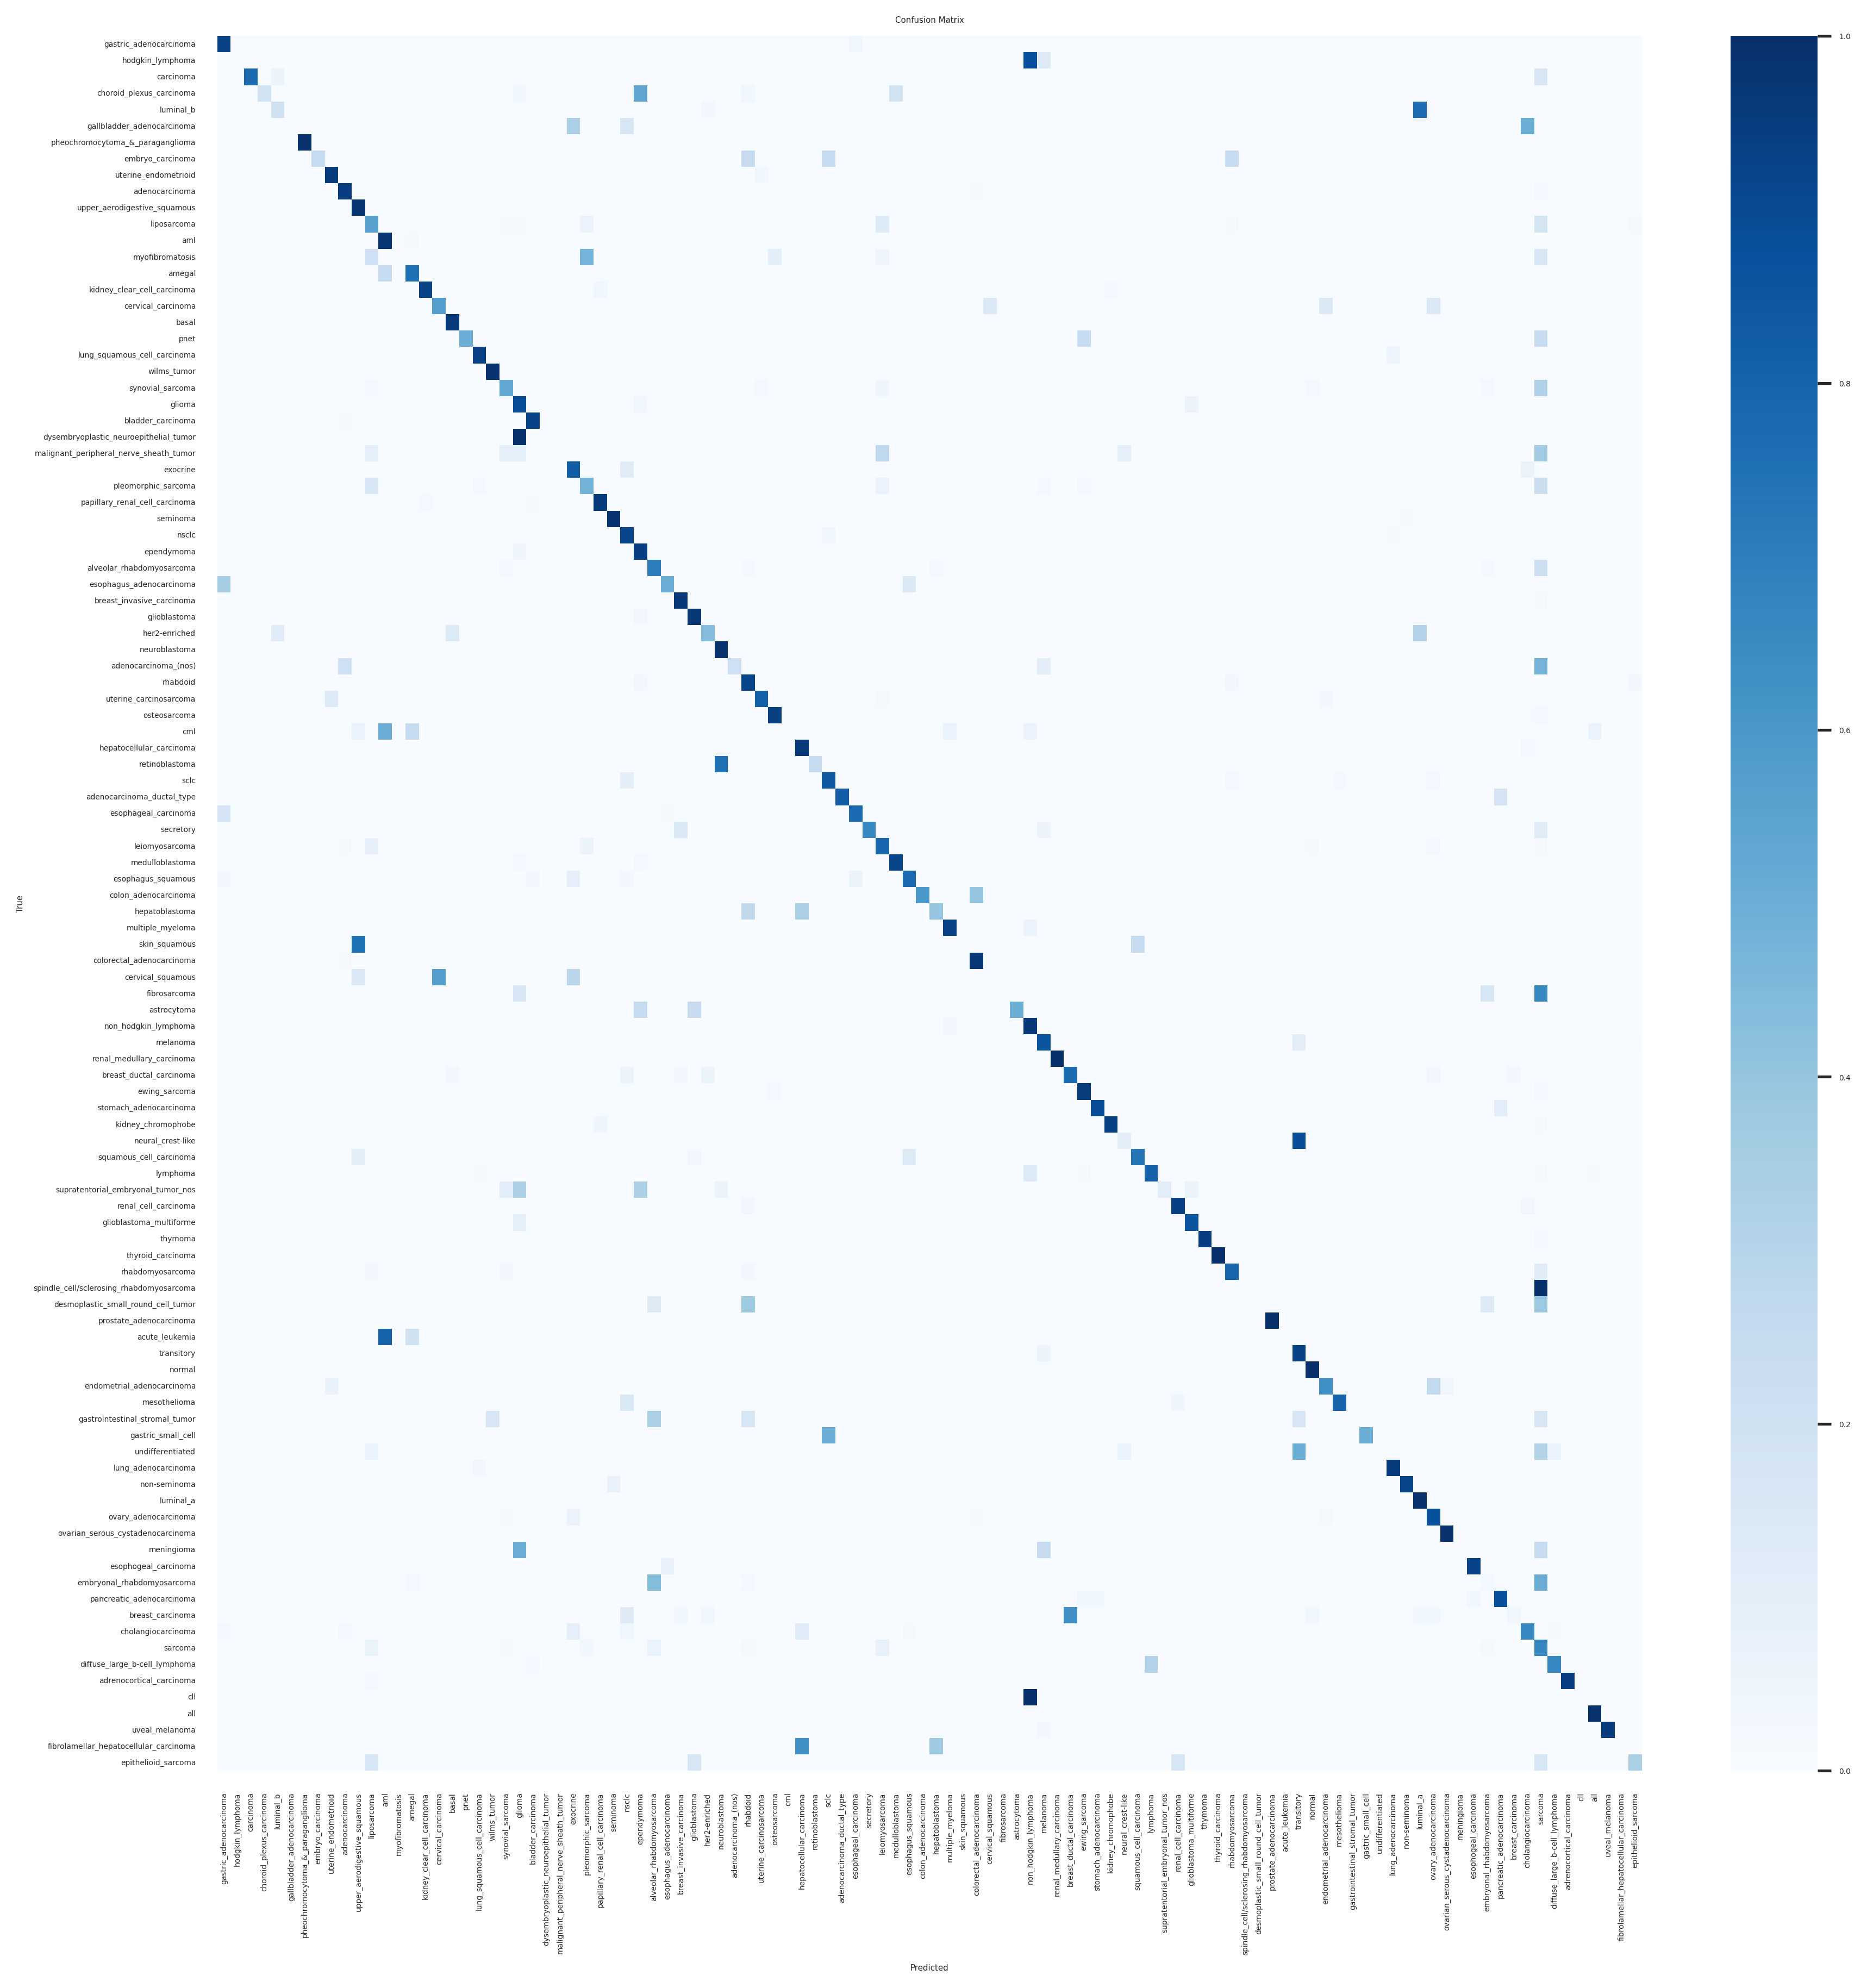

In [134]:
conf = evaluator.getconfusionMatrix(on="disease_type", only=None, figsize=(14,14), font_scale=.3)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'reference' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be r

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'passage_number' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'contamination' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated an

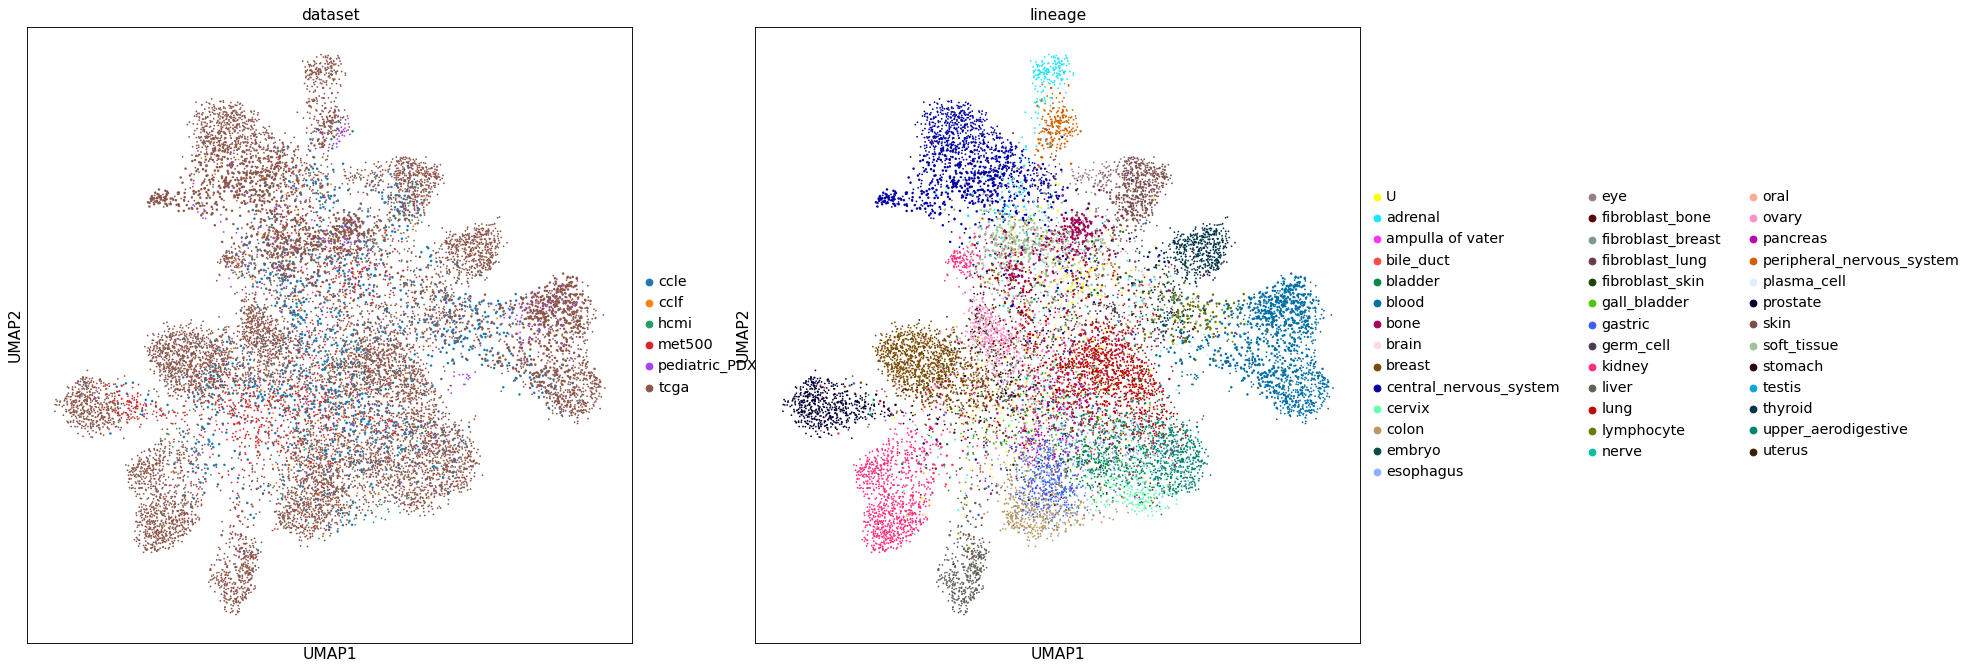

In [40]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
                    color=['dataset','lineage'],
                    projection="2d",
                    n_neighbors = 8,
                    rerun=True,
                    #add_outline = True,
                    size = [20] * len(dataset[dataset.obs['dataset']!='tcga']) + [10] * len(dataset[dataset.obs['dataset'] == 'tcga']))

/home/jeremie/celligner2/celligner2/plotting/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


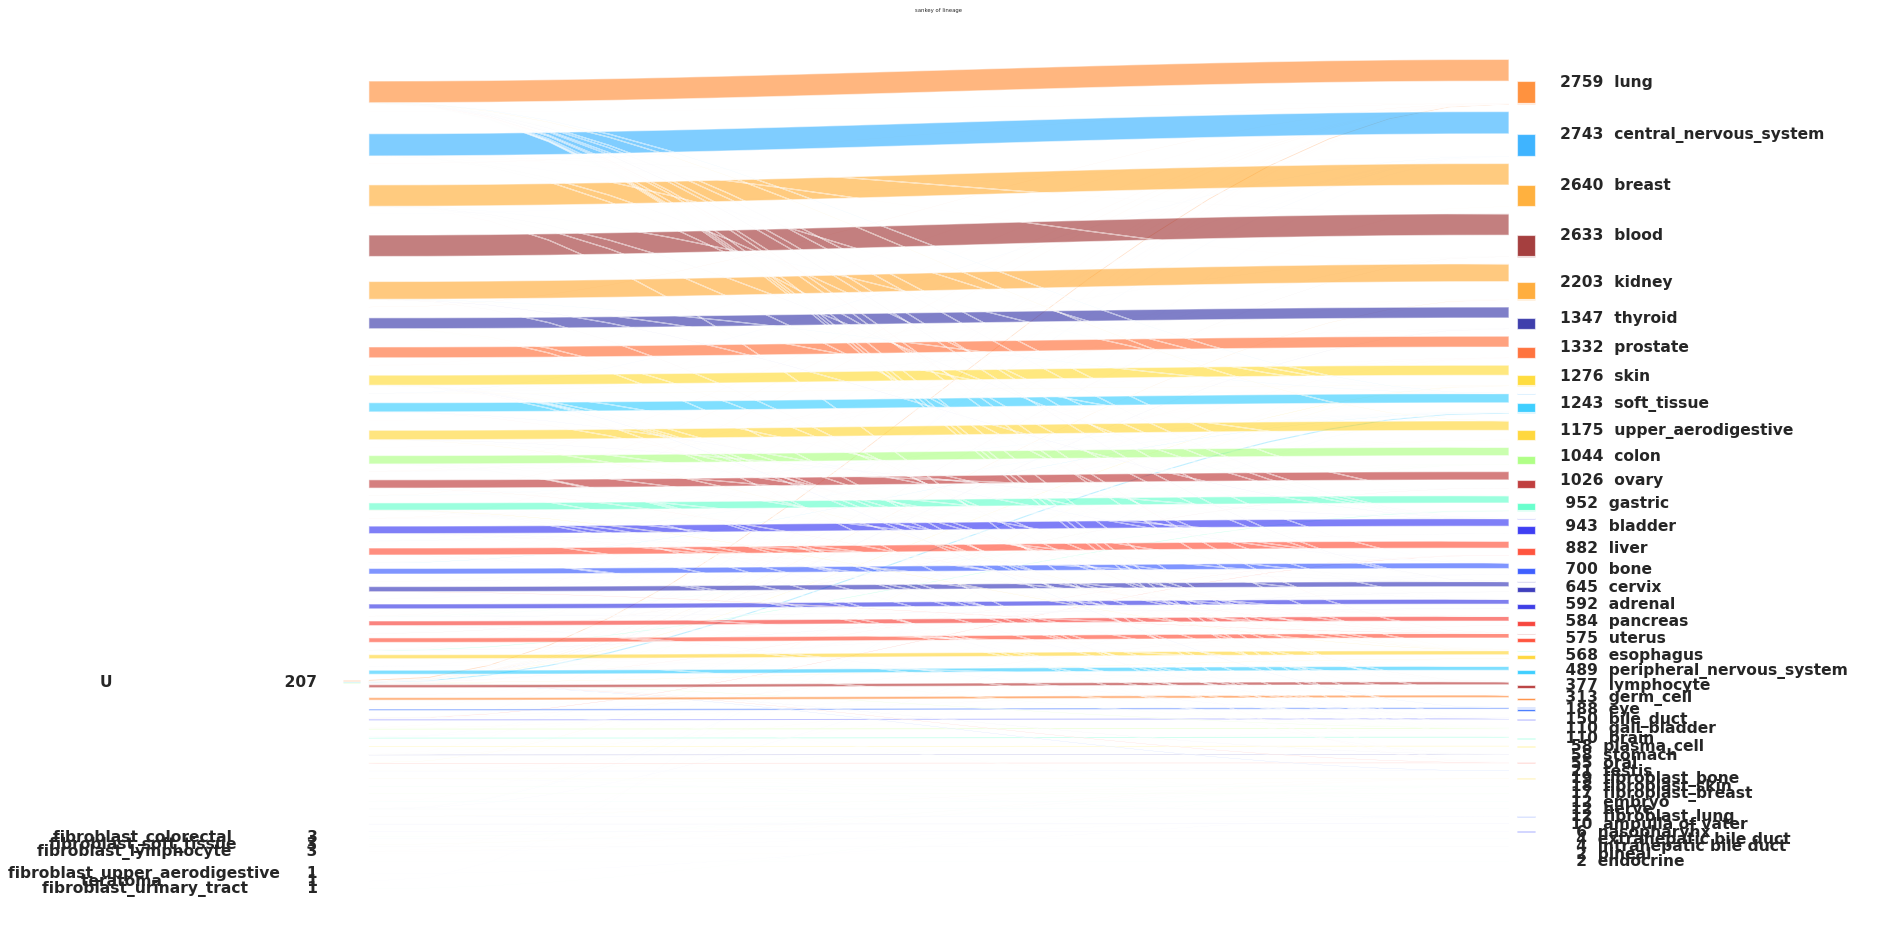

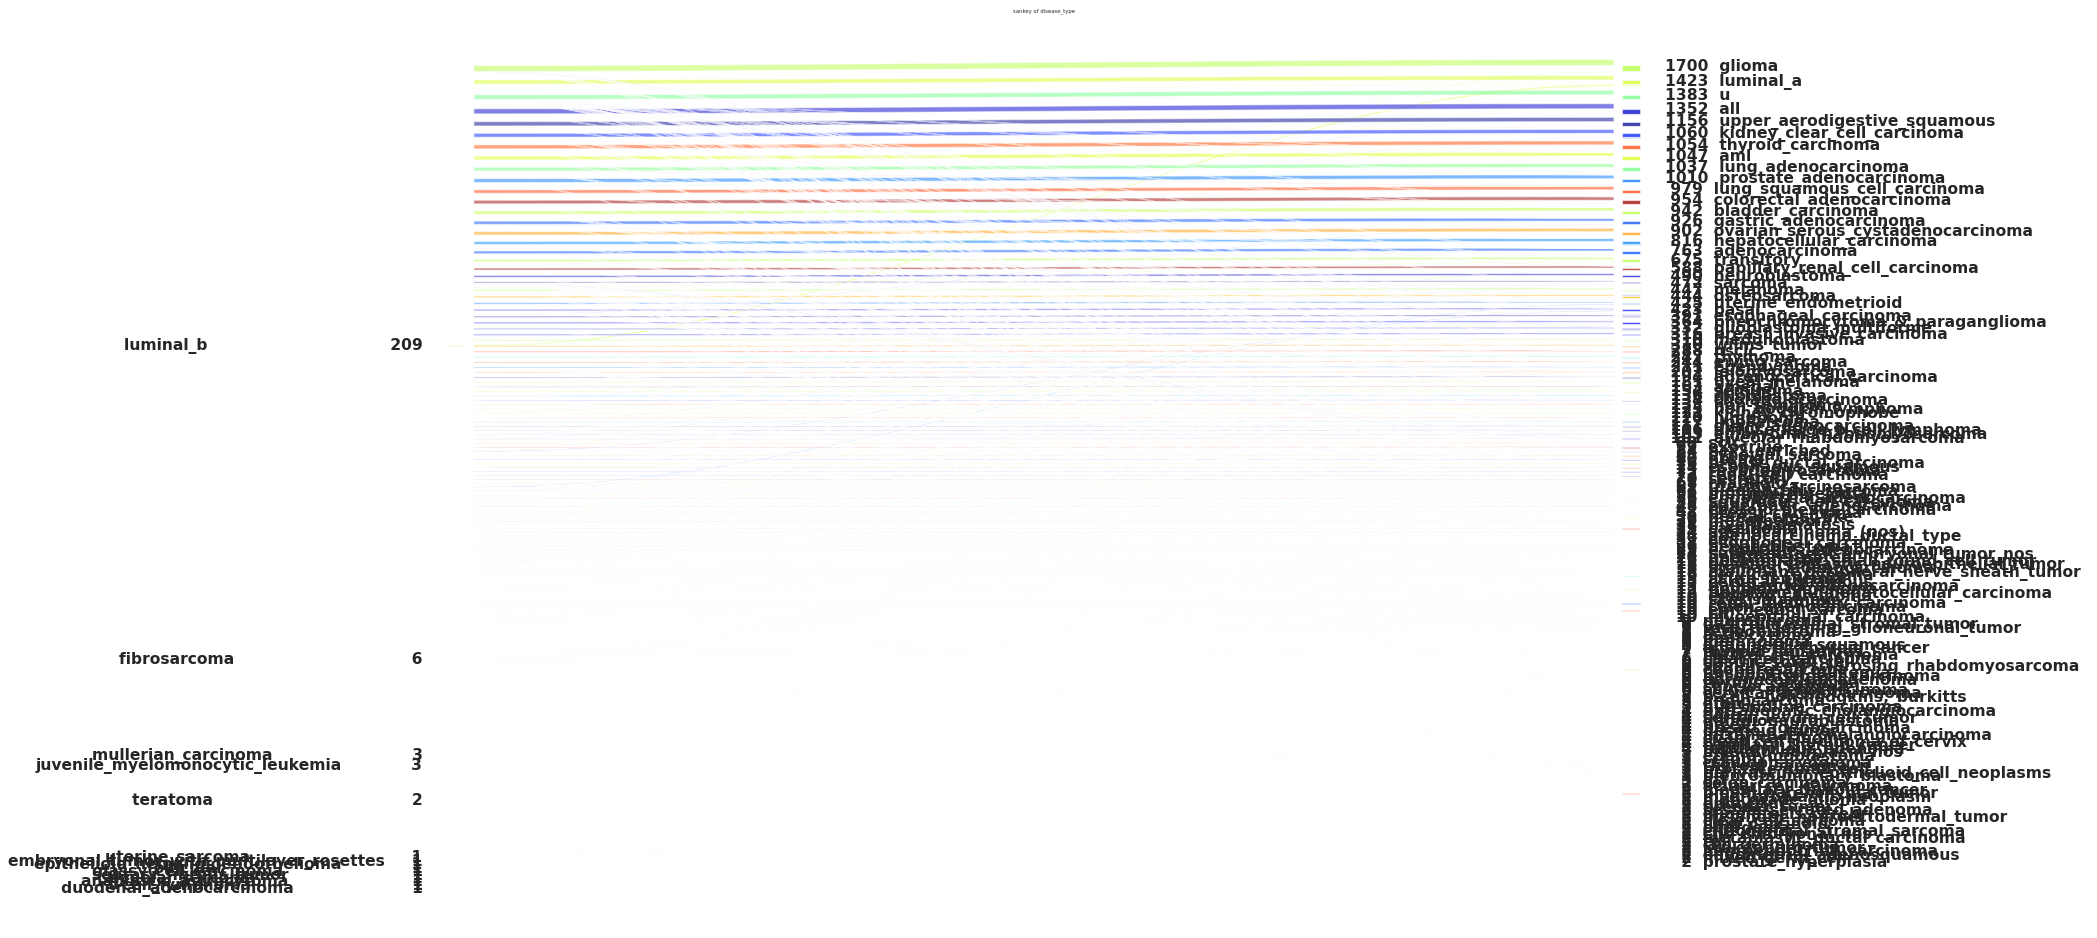

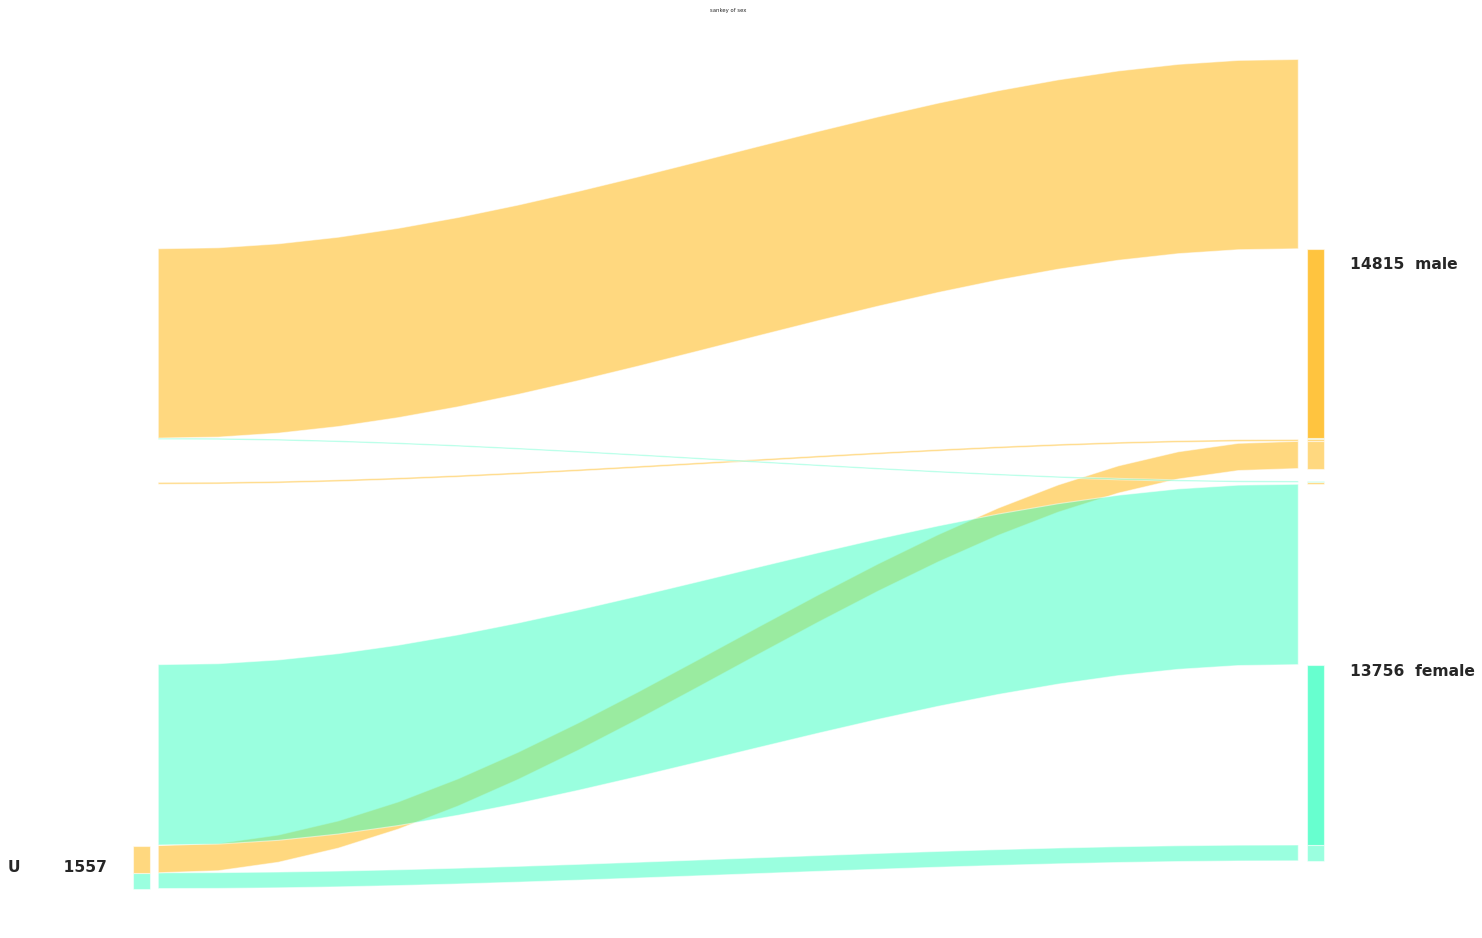

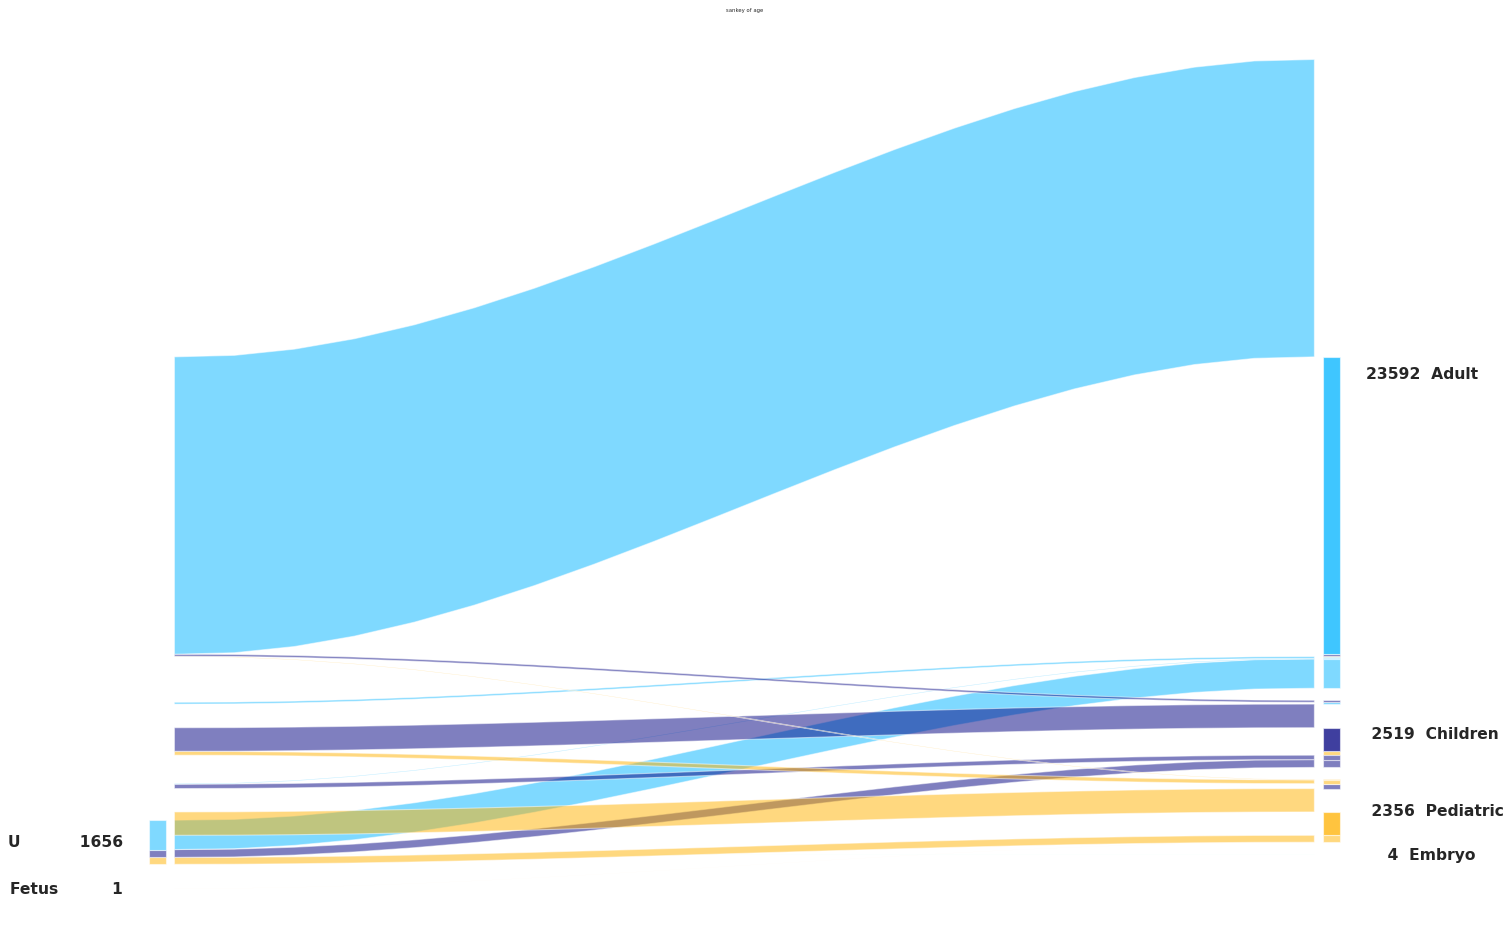

In [218]:
evaluator.plot_classification(classes=['lineage', 'disease_type', 'sex', 'age'])

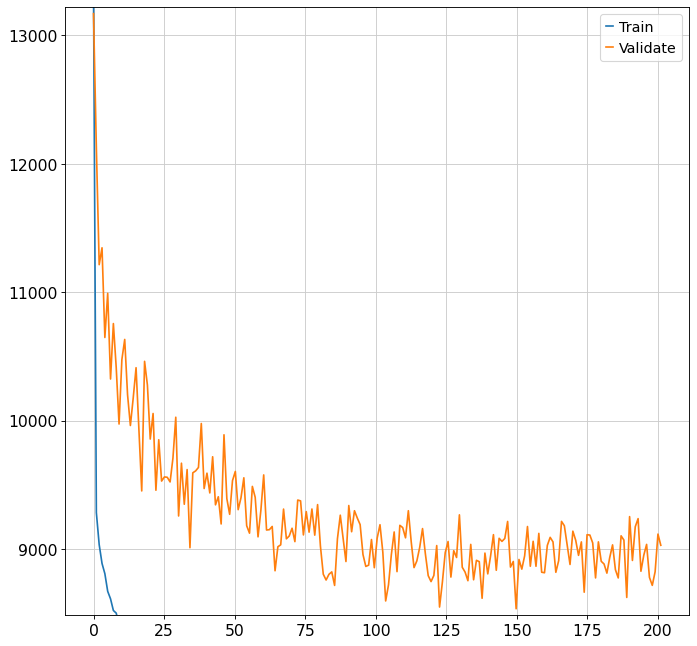

<Figure size 800x800 with 0 Axes>

In [31]:
evaluator.plot_history()

In [67]:
evaluator.get_asw(label_key='lineage')
evaluator.get_latent_score(label_key='lineage')
evaluator.get_nmi(label_key='lineage')

silhouette score...
ASW on batch: 0.904472541796136
ASW on celltypes: 0.5204207189381123
Calculating EBM with n_cat = 40
Latent-Space Score EBM+KNN, EBM, KNN: 0.64, 0.26, 0.38


ModuleNotFoundError: No module named 'louvain'

In [49]:
ccle_cond

dataset reference            sequencer sample_type align counter  \
sample_id                                                                     
ACH-001113    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-001289    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-001339    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-001538    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000242    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000708    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000327    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000233    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000461    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000705    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-001794    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-002023    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000528    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000167    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000792    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-001098    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000570    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000351    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000769    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   
ACH-000154    ccle      hg38  Illumina HiSeq 2000       model  STAR    RSEM   

           conservation cell_format  
sample_id                            
ACH-001113        fresh          2D  
ACH-001289        fresh          2D  
ACH-001339        fresh          2D  
ACH-001538        fresh          2D  
ACH-000242        fresh          2D  
ACH-000708        fresh          2D  
ACH-000327        fresh          2D  
ACH-000233        fresh          2D  
ACH-000461        fresh          2D  
ACH-000705        fresh          2D  
ACH-001794        fresh          2D  
ACH-002023        fresh          2D  
ACH-000528        fresh          2D  
ACH-000167        fresh          2D  
ACH-000792        fresh          2D  
ACH-001098        fresh          2D  
ACH-000570        fresh          2D  
ACH-000351        fresh          2D  
ACH-000769        fresh          2D  
ACH-000154        fresh          2D

In [50]:
evaluator.model.model.condition_encoder

{'Illlumina TruSeq': 0,
 'model': 1,
 'ccle': 2,
 'HTSEQ': 3,
 'BWA': 4,
 'conservation_frozen': 5,
 'pediatric_PDX': 6,
 'RSEM': 7,
 'cell_format_2D': 8,
 'met500': 9,
 'cell_format_PDX': 10,
 'hg19': 11,
 'cell_format_none': 12,
 'cell_format_3D': 13,
 'STAR': 14,
 'conservation_none': 15,
 'tissue': 16,
 'Illumina HiSeq 4000': 17,
 'cell_format_neuro': 18,
 'hcmi': 19,
 'premodel': 20,
 'none': 21,
 'hg38': 22,
 'cclf': 23,
 'conservation_fresh': 24,
 'Illumina HiSeq 2000': 25,
 'tcga': 26}

In [73]:
evaluator.adata_latent.group = [4,3,2,1]

In [79]:
evaluator.adata_latent

AnnData object with n_obs × n_vars = 14926 × 16
    obs: 'dataset', 'reference', 'sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format', 'lineage', 'collection_site', 'age', 'sex', 'disease_type', 'doublingt', 'cell_type', 'morphology', 'ethnicity', 'instability', 'hasebv', 'base_media', 'stage', 'passage_number', 'contamination', 'lineage_pred', 'collection_site_pred', 'age_pred', 'sex_pred', 'disease_type_pred', 'doublingt_pred', 'cell_type_pred', 'morphology_pred', 'ethnicity_pred', 'instability_pred', 'hasebv_pred', 'base_media_pred', 'stage_pred', 'passage_number_pred', 'contamination_pred', 'leiden'
    uns: 'neighbors', 'leiden', 'umap', 'dataset_colors', 'lineage_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
evaluator.reconstructionQC(cl2.adata.obs.loc[cl2.adata.obs.dataset=='tcga', cols].iloc[:20], cl2.adata.obs.loc[cl2.adata.obs.dataset=='ccle', cols].iloc[:size])

In [53]:
## what would it look like as tumor
#print(cl2_less.adata.obs.iloc[:100])
size = 20
cols = ['dataset','reference','sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format']

tcga_cond = cl2.adata.obs.loc[cl2.adata.obs.dataset=='tcga', cols].iloc[:20]

ccle_cond = cl2.adata.obs.loc[cl2.adata.obs.dataset=='ccle', cols].iloc[:size]

reco_tumor = cl2.reconstruct(evaluator.adata_latent[:size].X, tcga_cond)
reco = cl2.reconstruct(evaluator.adata_latent[:size].X, ccle_cond)
true = cl2.adata[:size].X

In [54]:
reco.columns = dataset.var.index
reco = AnnData(reco, cl2.adata.obs.iloc[:size], dataset.var)
reco_tumor.columns = dataset.var.index
reco_tumor = AnnData(reco_tumor, cl2.adata.obs.iloc[:size], dataset.var)
true.columns = dataset.var.index
true = AnnData(true, cl2.adata.obs.iloc[:size], dataset.var)

In [55]:
name = true.obs.index.tolist() + [i+"_reco" for i in reco.obs.index]
coeff = pd.DataFrame(data=np.corrcoef(true.X, reco.X), columns = name, index = name)

<AxesSubplot:>

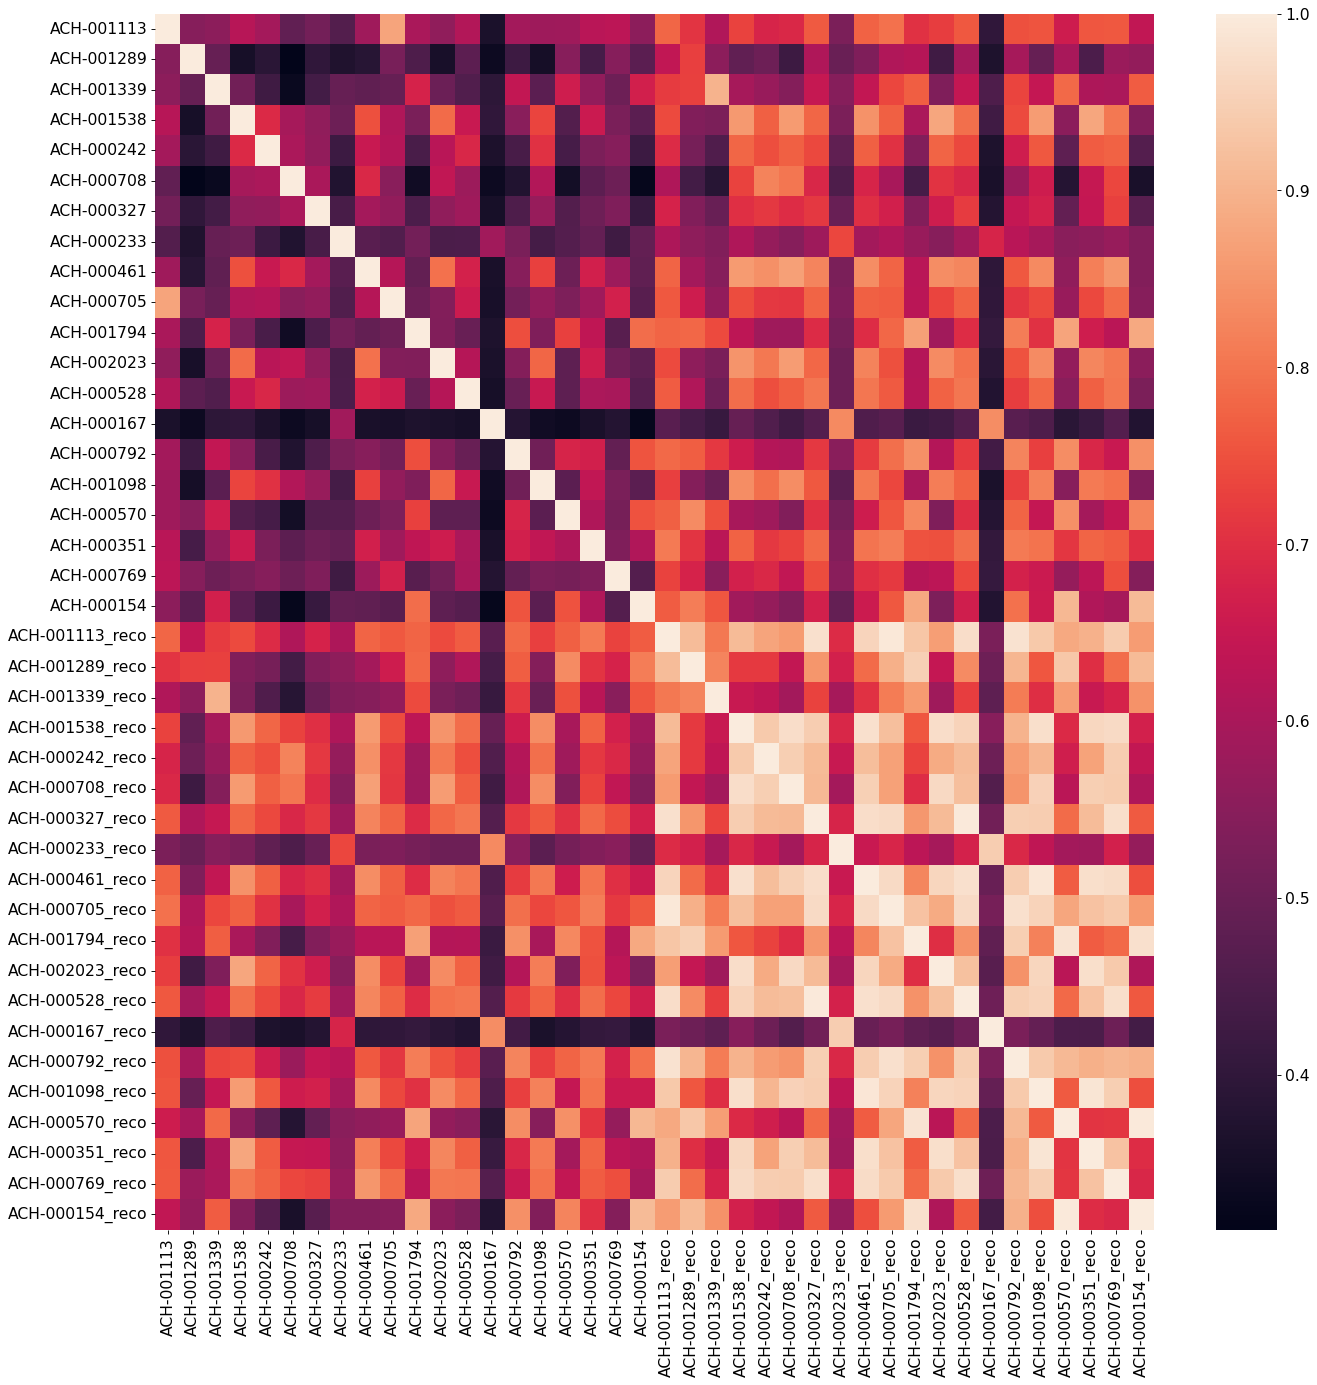

In [56]:
import seaborn as sns 
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(coeff, ax=ax)

In [58]:
sa = cl2.adata.obs
cl = sa[(sa.lineage=='gastric')&(sa.dataset=='ccle')].iloc[:size]
tm = sa[(sa.lineage=='gastric')&(sa.dataset=='tcga')].iloc[:size]

In [60]:
tcga_cond= tm[cols]
ccle_cond= cl[cols]
reco_tumor = cl2.reconstruct(evaluator.adata_latent[cl.index].X, tcga_cond)
reco = cl2.reconstruct(evaluator.adata_latent[cl.index].X, ccle_cond)
true = cl2.adata[cl.index].X
tumor_eq = cl2.adata[tm.index].X

In [61]:
reco.columns = dataset.var.index
reco = AnnData(reco, cl, dataset.var)
reco_tumor.columns = dataset.var.index
reco_tumor = AnnData(reco_tumor, cl, dataset.var)
true.columns = dataset.var.index
true = AnnData(true, cl, dataset.var)
tumor_eq.columns = dataset.var.index
tumor_eq = AnnData(tumor_eq, tm, dataset.var)

In [62]:
name = true.obs.index.tolist() + [i+"_reco" for i in reco.obs.index] + [i+"_reco_tumor" for i in reco.obs.index] + tumor_eq.obs.index.tolist()
coeff = pd.DataFrame(data=np.corrcoef(np.vstack([true.X,reco.X,reco_tumor.X, tumor_eq.X])), columns = name, index = name)

In [63]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],true.obs.index.tolist()].mean().mean()

0.48525195275694405

In [64]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],tumor_eq.obs.index.tolist()].mean().mean()

0.6554453415977888

In [65]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],[i+"_reco" for i in reco.obs.index]].mean().mean()

0.5987814333661786

<AxesSubplot:>

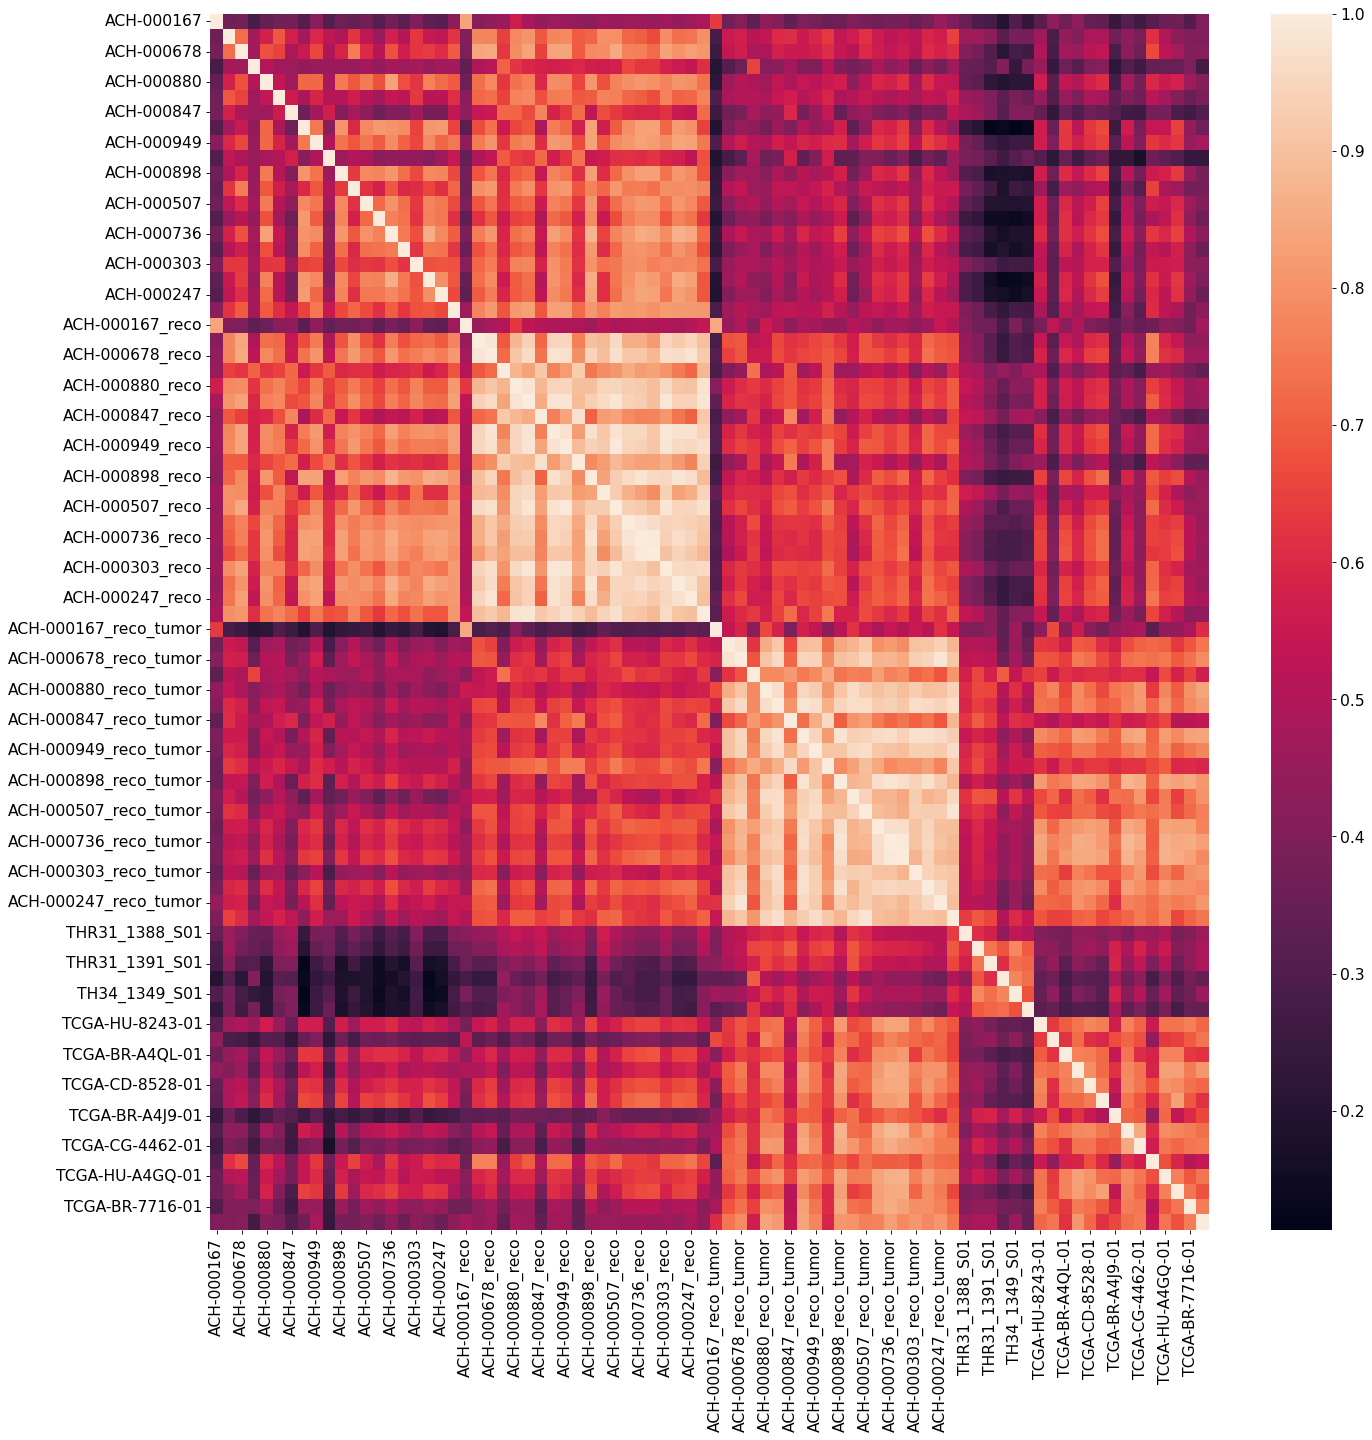

In [66]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(coeff, ax=ax)

In [ ]:
dataset.obs = evaluator.imputeMissingValues()

In [70]:
cols = ['dataset', 'reference', 'sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format', 'morphology', 'contamination']

In [71]:
pred = ['lineage', 'age', "sex", 'disease_type', 'cell_type', 'instability', 'hasebv', 'stage']

In [72]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset.copy(),
    condition_keys=cols,
    predictor_keys=pred,
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32, 64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8,
    #mmd_on='y1'
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 35
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 164 

Decoder Architecture:
	First Layer in, out and cond:  16 128 35
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RuntimeError: index -1 is out of bounds for dimension 1 with size 35

39,000,000 input 

811,852 parameter

## zenodo

In [ ]:
ACCESS_TOKEN = "YOURTOKEN"
deposition_id = sca.zenodo.create_deposition(ACCESS_TOKEN,
                                             upload_type="other",
                                             title='Celligner2',
                                             description='test CL2 upload',
                                             creators=[
                                                 {"name": "Jeremie, Kalfon", 
                                                  "affiliation": "Broad Institute", 
                                                  "orcid": ""},
                                             ]
                                             )

In [ ]:
download_link = sca.zenodo.upload_model('./model/cl2',
                                        deposition_id=deposition_id,
                                        access_token=ACCESS_TOKEN,
                                        model_name='CL2')

In [ ]:
sca.zenodo.publish_deposition(deposition_id, ACCESS_TOKEN)

In [ ]:
model_path = sca.zenodo.download_model(download_link, './surg_model/', make_dir=True)
new_cl2 = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=model_path)